# Red Neuronal Densa de Clasificación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [2]:
#Librerias de keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [3]:
# importamos las métricas que usaremos:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer

In [4]:
# Importar Dataset como dataframe de pandas
df = pd.read_csv("../Data/stroke_data.csv")

#tutor
# df = pd.read_csv("stroke_data.csv")

df.shape

(5110, 11)

In [5]:
target_col = 'stroke'

X = df.drop([target_col], axis=1)
y = df[target_col]

y = y.rename("stroke")

print(X.shape, y.shape)

(5110, 10) (5110,)


In [6]:
# Asegúrate de que X_train es un array de NumPy
if not isinstance(X, np.ndarray):
    X_train = np.array(X)

# Asegúrate de que y_train es un array de NumPy
if not isinstance(y, np.ndarray):
    y_train = np.array(y)

In [7]:
#separar train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Modelo

In [8]:
#Necesitamos añadir el número de características (features para la dimension del input)
num_features = X_train.shape[1]

**Nota:**

Para poder incluir el número de capas en la búsqueda de hiperparametros hay que añadir un bulce for.

In [9]:
def create_model(optimizer='adam', activation='relu', dropout_rate=0.5, neurons=64, num_layers=1):
    model = Sequential()
    
    # Capa de entrada
    model.add(Input(shape=(num_features,)))
    
    # Añadir capas ocultas de acuerdo a num_layers
    for i in range(num_layers):
        model.add(Dense(neurons, activation=activation))
        model.add(Dropout(dropout_rate))
        neurons = neurons // 2  # Opcional: reducir el número de neuronas en cada capa

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilar el modelo
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [10]:
# Crear el clasificador Keras
keras_clf = KerasClassifier(model=create_model, epochs=50, batch_size=32, verbose=0)

In [11]:
from imblearn.pipeline import Pipeline as ImbPipeline

# Definir el pipeline con SMOTE, estandarización y el modelo Keras
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),  # Estandarizar los datos
    ('smote', SMOTE(random_state=0)),  # Aplicar SMOTE
    ('keras', keras_clf)  # Modelo de clasificación con red neuronal
])

# CV del modelo

In [12]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

# importamos las métricas que usaremos:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer


# Función para calcular múltiples métricas
def calculate_metrics(estimator, X, y, cv):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f3_scores = []
    
    f3_scorer = make_scorer(fbeta_score, beta=3, zero_division=1)
    
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = clone(estimator)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f3_scores.append(fbeta_score(y_test, y_pred, beta=2, zero_division=1))
    
    return {
        'accuracy': np.mean(accuracy_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f3_score': np.mean(f3_scores)
    }

# Definir validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Calcular métricas con validación cruzada
metrics = calculate_metrics(pipeline, X_train, y_train, cv)

# Imprimir los resultados de la validación cruzada
print(f"Accuracy promedio: {metrics['accuracy']}")
print(f"Precision promedio: {metrics['precision']}")
print(f"Recall promedio: {metrics['recall']}")
print(f"F3 Score promedio: {metrics['f3_score']}")

Accuracy promedio: 0.77580966519514
Precision promedio: 0.12426091964907529
Recall promedio: 0.6
F3 Score promedio: 0.33745167987129


# Optimización de hiperparámetros

In [13]:
from sklearn.model_selection import GridSearchCV

param_distributions = {
    'keras__model__optimizer': ['adam'],
    'keras__model__activation': ['relu', 'tanh', 'sigmoid', 'elu'],
    'keras__model__dropout_rate': [0.1, 0.3, 0.5],
    'keras__model__neurons': [32, 64, 128],
    'keras__model__num_layers': [1, 2, 3, 4],
    'keras__epochs': [50, 100],
    'keras__batch_size': [16, 32, 64]
}

In [14]:
from sklearn.metrics import make_scorer, fbeta_score
# Definir el f3 score como métrica de evaluación
f3_scorer = make_scorer(fbeta_score, beta=3, zero_division=1)

# Configurar RandomizedSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_distributions,
    cv=5,  # Número de pliegues en validación cruzada
    scoring=f3_scorer,  # Métrica para evaluar el rendimiento
    n_jobs=-1,  # Usa todos los núcleos disponibles
    verbose=1
)

# Ajustar RandomizedSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros encontrados por Random Search
best_params_random = grid_search.best_params_
print("Mejores parámetros de Random Search:", best_params_random)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


c:\Users\vgarc\Documents\TFM\.venv\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros de Random Search: {'keras__batch_size': 64, 'keras__epochs': 50, 'keras__model__activation': 'sigmoid', 'keras__model__dropout_rate': 0.1, 'keras__model__neurons': 64, 'keras__model__num_layers': 1, 'keras__model__optimizer': 'adam'}
Best score:  0.5245124164251683


In [15]:
# Definir validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#Instanciamos el mejor modelo con los hiperparametros del grid
best_model = grid_search.best_estimator_

# Calcular métricas con validación cruzada
metrics = calculate_metrics(best_model, X_train, y_train, cv)

# Imprimir los resultados de la validación cruzada
print(f"Accuracy promedio: {metrics['accuracy']}")
print(f"Precision promedio: {metrics['precision']}")
print(f"Recall promedio: {metrics['recall']}")
print(f"F3 Score promedio: {metrics['f3_score']}")

Accuracy promedio: 0.7411427120365668
Precision promedio: 0.1321462250220085
Recall promedio: 0.7742857142857144
F3 Score promedio: 0.3913908758188718


Accuracy: 0.7475538160469667
Precision: 0.13238770685579196
Recall: 0.7368421052631579
F1 Score: 0.22444889779559118
F3 Score: 0.5058717253839206


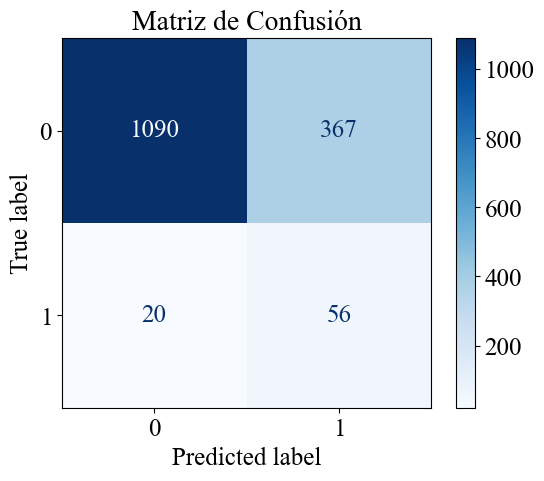

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib as mpl

# Configurar la fuente a Times New Roman y aumentar el tamaño de la fuente
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 18  # Aumentar el tamaño de la fuente a 14 (puedes cambiar este valor)

# Realizar predicciones en el conjunto de prueba
y_pred_op = best_model.predict(X_test)

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred_op)
precision = precision_score(y_test, y_pred_op)
recall = recall_score(y_test, y_pred_op)
f1 = f1_score(y_test, y_pred_op)
f3 = fbeta_score(y_test, y_pred_op, beta=3, zero_division=1)

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("F3 Score:", f3)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_op)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Ajustar título y mostrar la matriz de confusión
plt.title('Matriz de Confusión', fontsize=20)  # Tamaño de fuente específico para el título
plt.show()

# Guardar Modelo

In [17]:
import joblib

# Guardar la pipeline completa
joblib.dump(best_model, '../Modelos/DNNClasiffier.pkl')

['../Modelos/DNNClasiffier.pkl']

# Modelo 1 neurona

In [18]:
# Añadir una capa densa con una sola neurona y activación sigmoide
# Definir el modelo
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))
# Compilar el modelo
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Crear el clasificador Keras
keras_clf = KerasClassifier(model=create_model, epochs=50, batch_size=32, verbose=0)


pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=0)),  # Aplicar SMOTE para balancear las clases
    ('scaler', StandardScaler()),  # Estandarizar los datos
    ('keras', keras_clf)  # Modelo de clasificación con red neuronal
])

# Definir validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Calcular métricas con validación cruzada
metrics = calculate_metrics(pipeline, X_train, y_train, cv)

# Imprimir los resultados de la validación cruzada
print(f"Accuracy promedio: {metrics['accuracy']}")
print(f"Precision promedio: {metrics['precision']}")
print(f"Recall promedio: {metrics['recall']}")
print(f"F2 Score promedio: {metrics['f2_score']}")

c:\Users\vgarc\Documents\TFM\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy promedio: 0.8054400906356214
Precision promedio: 0.1210055206936862
Recall promedio: 0.4798319327731092


KeyError: 'f2_score'